In [10]:
#import essential tools and packs
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [11]:
#load the Tesla stock data using yfinance
start_date = '2023-01-01'
end_date = '2024-01-31'
stock_symbol = 'TSLA'
stock = yf.download(stock_symbol, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


In [12]:
def garch(param, *args):
    # Initialize Params
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    GARCH_Dens, sigma2, F, v = {}, {}, {}, {} 
    # intialize values 
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * (sigma2[t-1])
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1 / 2) * np.log(2 * np.pi) + (1 / 2) * np.log(v[t]) + (1 / 2) * (F[t] / v[t])
        Likelihood += GARCH_Dens[t]  
    
    return Likelihood


In [13]:
def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    sigma2, path = {}, {}
    # initialize volatility and path
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * (sigma2[t-1])
        path[t] = mu + np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)    
        
    return path, sigma2    

         Current function value: -1797.759276
         Iterations: 2
         Function evaluations: 112
         Gradient evaluations: 20


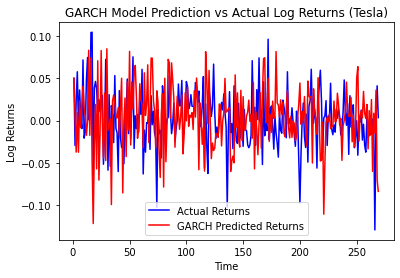

RMSE value is: 0.04901594213301515%


In [31]:
#GARCH model to forecast stock return
Y = np.diff(np.log(stock['Adj Close'].values))
T = Y.shape[0]

param0 = np.array([np.mean(Y), np.var(Y) / 1000, 0.3, 0.75])
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x

path, vol = garch_path(param_star, Y, T)
Y_GARCH = path.values()

timevec = np.linspace(1, T, T)
plt.plot(timevec, Y, 'b', timevec, Y_GARCH, 'r')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('GARCH Model Prediction vs Actual Log Returns (Tesla)')
plt.legend(['Actual Returns', 'GARCH Predicted Returns'])
plt.show()

# Extracting the dictionary values into a list (in the same order as keys)
GARCH_prediction = list(Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction) - np.array(Y)) ** 2))
print(f'RMSE value is: {RMSE}%')


Optimization terminated successfully.
         Current function value: 908.699929
         Iterations: 33
         Function evaluations: 210
         Gradient evaluations: 42


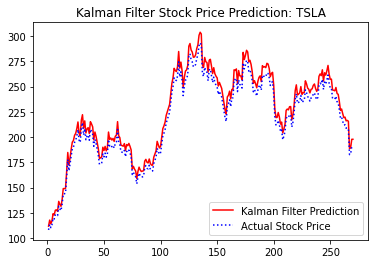

RMSE value is: $ 7.807521011190385


In [28]:
#Kalman filter code to predict Tesla's daily stock prices
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

def kalman_filter(param, *args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict, u_update, P_predict, P_update, v, F = {}, {}, {}, {}, {}, {}
    Y, S = args
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y) / 4
    P_predict[0] = T * P_update[0] * np.transpose(T) + Q
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z * P_predict[s - 1] * np.transpose(Z) + H
        v[s] = Y[s - 1] - Z * u_predict[s - 1]
        u_update[s] = u_predict[s - 1] + P_predict[s - 1] * np.transpose(Z) * (1 / F[s]) * v[s]
        u_predict[s] = T * u_update[s]
        P_update[s] = P_predict[s - 1] - P_predict[s - 1] * np.transpose(Z) * (1 / F[s]) * Z * P_predict[s - 1]
        P_predict[s] = T * P_update[s] * np.transpose(T) + Q
        Likelihood += (1 / 2) * np.log(2 * np.pi) + (1 / 2) * np.log(abs(F[s])) + (1 / 2) * np.transpose(v[s]) * (1 / F[s]) * v[s]

    return Likelihood

def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    # initialize vector values:
    u_predict, u_update, P_predict, P_update, v, F = {}, {}, {}, {}, {}, {}
    Y, S = args
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y) / 4
    P_predict[0] = T * P_update[0] * np.transpose(T) + Q
    for s in range(1, S):
        F[s] = Z * P_predict[s - 1] * np.transpose(Z) + H
        v[s] = Y[s - 1] - Z * u_predict[s - 1]
        u_update[s] = u_predict[s - 1] + P_predict[s - 1] * np.transpose(Z) * (1 / F[s]) * v[s]
        u_predict[s] = T * u_update[s]
        P_update[s] = P_predict[s - 1] - P_predict[s - 1] * np.transpose(Z) * (1 / F[s]) * Z * P_predict[s - 1]
        P_predict[s] = T * P_update[s] * np.transpose(T) + Q

    u_smooth, P_smooth = {}, {}
    u_smooth[S - 1] = u_update[S - 1]
    P_smooth[S - 1] = P_update[S - 1]
    for t in range(S - 1, 0, -1):
        u_smooth[t - 1] = u_update[t] + P_update[t] * np.transpose(T) / P_predict[t] * (u_smooth[t] - T * u_update[t])
        P_smooth[t - 1] = P_update[t] + P_update[t] * np.transpose(T) / P_predict[t] * (P_smooth[t] - P_predict[t]) / P_predict[t] * T * P_update[t]

    smooth_path = u_smooth
    return smooth_path

Y = stock['Adj Close'].values
S = Y.shape[0]

# Initial parameters
param0 = np.array([1.65, 0.95, np.var(Y) / 60, np.var(Y) / 30])
results = minimize(kalman_filter, param0, args=(Y, S), method='BFGS', tol=1e-2, options={'disp': True})

# Smoothe and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()

# Plotting results
timevec = np.linspace(1, S, S)
plt.title('Kalman Filter Stock Price Prediction: ' + stock_symbol)
plt.plot(timevec, Y_kalmanFilter, 'r', label='Kalman Filter Prediction')
plt.plot(timevec, Y, 'b:', label='Actual Stock Price')
plt.legend()
plt.show()

# Extracting the dictionary values into a list (in the same order as keys)
kalman_values = list(Y_kalmanFilter)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(kalman_values) - np.array(Y)) ** 2))
print('RMSE value is: $', RMSE)
